In [38]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface, VAEPWVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

from src.utils.logger import setup_logger
logger = setup_logger('train')

In [39]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-23 17:09:06] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-23 17:09:18] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-23 17:09:19] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-23 17:09:19] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


In [40]:
model_name = "vae_pw_improve_0"
train_model = False
load_model = True
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-23 17:09:19] [INFO] src.train (62) : Using device: mps


In [41]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

with open(data_dir, "r") as f:
    data = json.load(f)

mapping_dict = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_dict)

vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['moneyness', 'ttm']].values, dtype=torch.float32)
# !only for test run
# pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [42]:
trainer.load_model( f"params/{trainer.model_name}.pth")

[2025-04-23 17:09:22] [INFO] src.train (138) : Model loaded from params/vae_pw_improve_0.pth


In [43]:
trainer.model.eval()
data_tensor = data_tensor.to(trainer.device)
encoder_outputs_mean = []
encoder_outputs_logvar = []
with torch.no_grad(): 
    for input_data in data_tensor:
        encoder_output = trainer.model.encoder(input_data.unsqueeze(0))
        encoder_outputs_mean.append(encoder_output[0])
        encoder_outputs_logvar.append(encoder_output[1])
encoder_outputs_mean = torch.cat(encoder_outputs_mean, dim=0)
encoder_outputs_logvar = torch.cat(encoder_outputs_logvar, dim=0)

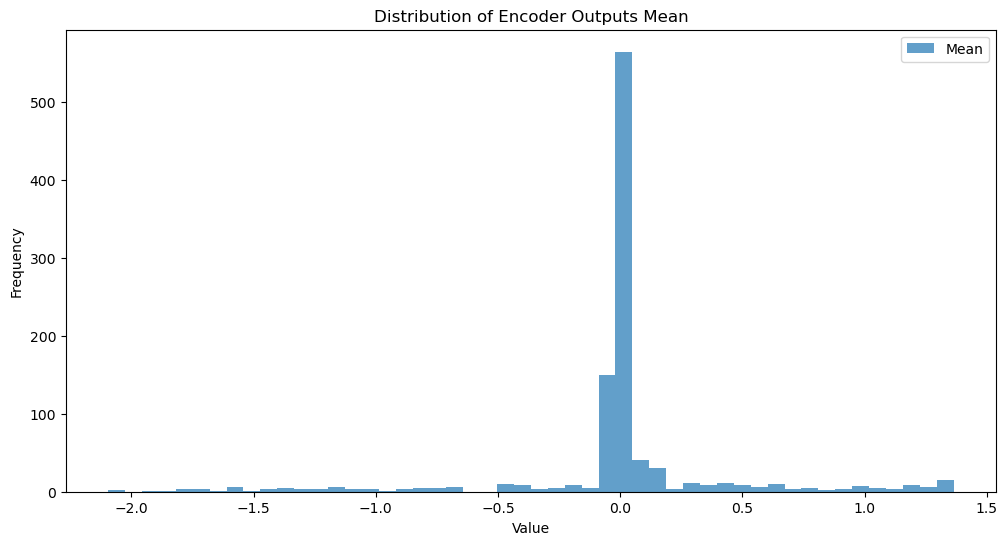

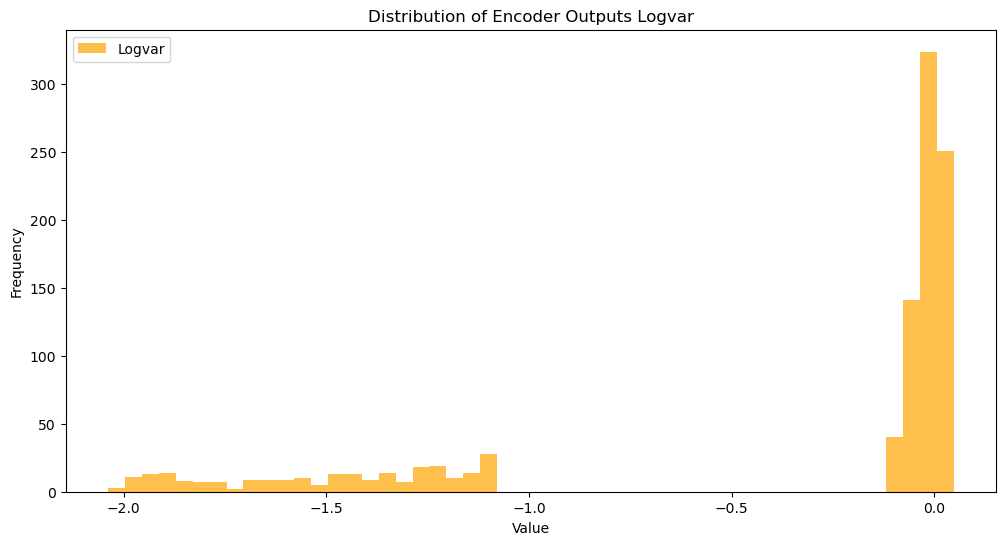

In [44]:
import matplotlib.pyplot as plt

# Plot the distribution of mean
plt.figure(figsize=(12, 6))
plt.hist(encoder_outputs_mean.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Mean')
plt.title('Distribution of Encoder Outputs Mean')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the distribution of logvar
plt.figure(figsize=(12, 6))
plt.hist(encoder_outputs_logvar.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Logvar', color='orange')
plt.title('Distribution of Encoder Outputs Logvar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

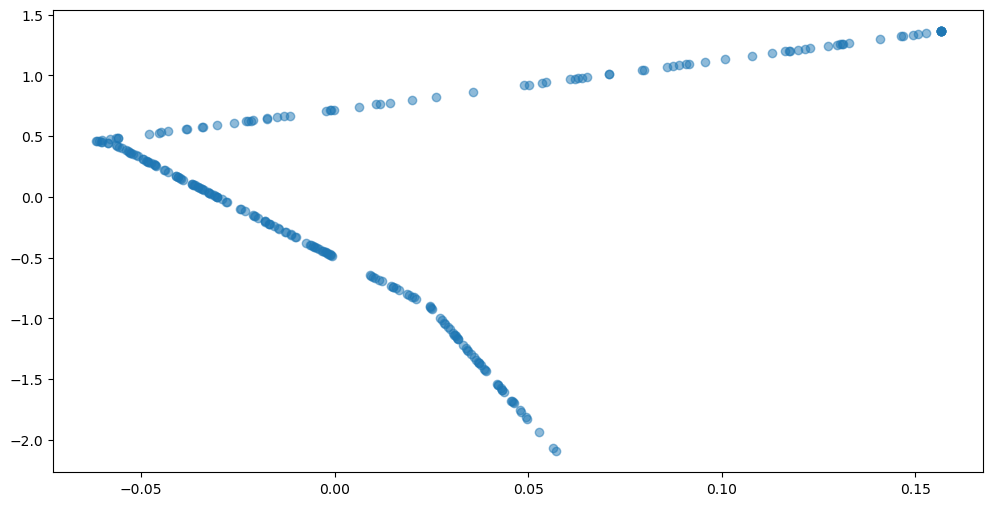

In [45]:
encoder_outputs_mean_ = encoder_outputs_mean.cpu().numpy()
# compute variance for encoder outputs mean
encoder_outputs_mean_var = np.var(encoder_outputs_mean_, axis=0)
# get the indices of the largest 2 var
indices = np.argsort(encoder_outputs_mean_var)[-2:]
encoder_outputs_mean_ = encoder_outputs_mean_[:, indices]
# plot
plt.figure(figsize=(12, 6))
plt.scatter(encoder_outputs_mean_[:, 0], encoder_outputs_mean_[:, 1], alpha=0.5)

In [46]:
vix_data  = pd.read_csv(CSV_PATH + "/VIX_HISTORY.csv",parse_dates=['DATE'])
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')
vix_close = vix_data.loc[df.date.unique()]['CLOSE'].values

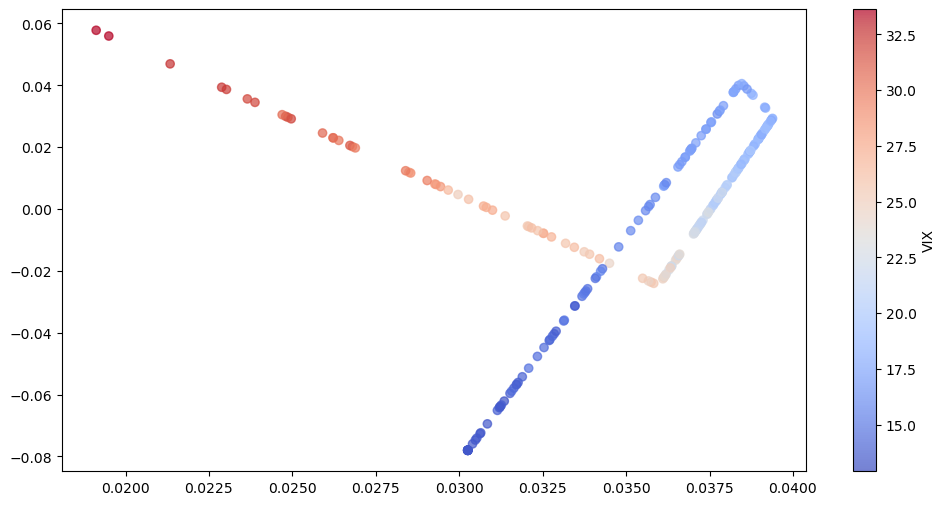

In [47]:
vix_close_scale = (vix_close - np.mean(vix_close)) / np.std(vix_close)
encoder_outputs_mean_ = encoder_outputs_mean.cpu().numpy()
# compute variance for encoder outputs mean
encoder_outputs_mean_var = np.var(encoder_outputs_mean_, axis=0)
# get the indices of the largest 2 var
indices = np.argsort(encoder_outputs_mean_var)[:]
encoder_outputs_mean_ = encoder_outputs_mean_[:, indices]
# plot
plt.figure(figsize=(12, 6))
ld = plt.scatter(encoder_outputs_mean_[:, 0], encoder_outputs_mean_[:, 1], alpha=0.7, c = vix_close, cmap='coolwarm')
plt.colorbar(ld, label="VIX")

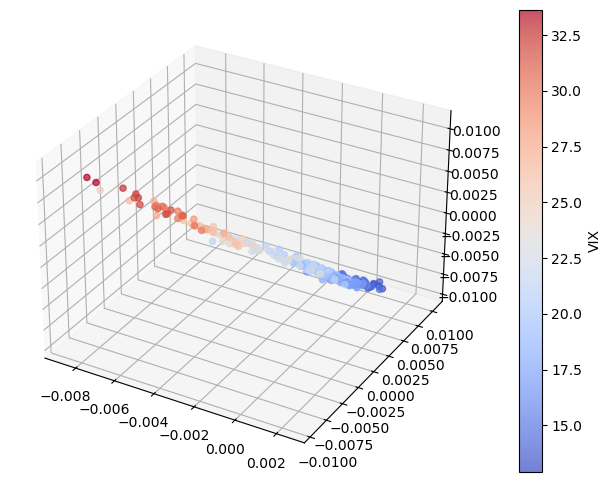

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ld = ax.scatter(encoder_outputs_mean_[:, 0], encoder_outputs_mean_[:, 2], encoder_outputs_mean_[:, 3], alpha=0.7, c = vix_close, cmap='coolwarm')
plt.colorbar(ld, label="VIX")

In [12]:
from sklearn.linear_model import LinearRegression

x = encoder_outputs_mean_[:, 0].reshape(-1, 1)  
y = encoder_outputs_mean_[:, 1]
model = LinearRegression()
model.fit(x, y)

slope = model.coef_[0]
intercept = model.intercept_

x_min, x_max = x.min(), x.max()
random_x = np.random.uniform(x_min, x_max) 
random_y = slope * random_x + intercept  

random_point = (random_x, random_y)

print(f"Random point on the line: {random_point}")

Random point on the line: (-0.006955651824765611, np.float32(-0.008345631))


<Axes3D: title={'center': 'Vol Surface'}, xlabel='Delta', ylabel='Maturity (Days)', zlabel='Implied Volatility'>

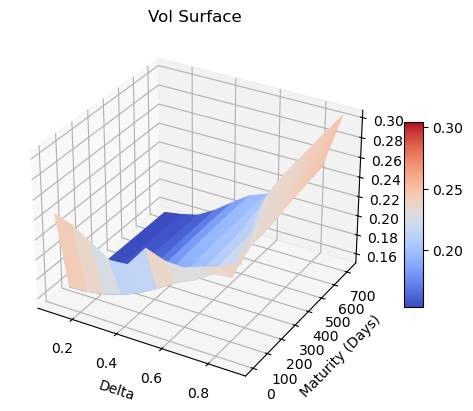

In [35]:
# generate random points in the latent space
def normal_rng(shape, mean=None, std=1.0):
    random_x = np.random.uniform(x_min, x_max) 
    random_y = slope * random_x + intercept  
    rng = np.random.default_rng()
    while True:
        # Generate a sample with separate means for each dimension
        yield rng.normal(loc=[random_x, random_y, 0, 0], scale=std, size=shape)

test_rng = normal_rng(4)
vae_gen = VAEPWVolSurface(
    vae_model=trainer.model,
    latent = next(test_rng)
)
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)
vae_gen.plot(delta_range = (0.1, 0.9), maturity_range = (1, 720))

In [36]:
vol_surfaces[0]

tensor([1.8353e-01, 1.9189e-01, 1.9204e-01, 1.8141e-01, 1.7995e-01, 1.7564e-01,
        1.7915e-01, 2.8276e-06, 1.9834e-01, 2.0240e-01, 2.0094e-01, 1.9175e-01,
        1.9086e-01, 1.8854e-01, 1.8913e-01, 2.9579e-06, 2.0573e-01, 2.0974e-01,
        2.1067e-01, 2.0333e-01, 2.0298e-01, 2.0199e-01, 1.9388e-01, 3.1152e-06,
        2.1150e-01, 2.1673e-01, 2.2111e-01, 2.1574e-01, 2.1663e-01, 2.1628e-01,
        2.1002e-01, 3.3693e-06, 2.1740e-01, 2.2425e-01, 2.3255e-01, 2.2974e-01,
        2.3139e-01, 2.3127e-01, 2.2657e-01, 3.6413e-06, 2.2177e-01, 2.3106e-01,
        2.4476e-01, 2.4454e-01, 2.4744e-01, 2.4798e-01, 2.4389e-01, 3.9184e-06,
        2.2393e-01, 2.3717e-01, 2.5881e-01, 2.6077e-01, 2.6456e-01, 2.6729e-01,
        2.6208e-01, 4.2447e-06, 2.3202e-01, 2.4938e-01, 2.7747e-01, 2.8195e-01,
        2.8848e-01, 2.9385e-01, 2.8267e-01, 4.7227e-06, 2.6301e-01, 2.8156e-01,
        3.1693e-01, 3.2693e-01, 3.3565e-01, 3.5307e-01, 3.5037e-01, 5.9509e-06])

In [76]:
print(next(test_rng))


[-1.18762092  0.47817931 -0.46940234  0.01249412]
